# Image Processing

In [2]:
# Import Dependencies

# General libraries / functions
import pandas as pd
import numpy as np
import pickle
import glob
import random
import math

# Image libaries / functions
from skimage import io
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, disk, dilation
from scipy.ndimage.morphology import binary_fill_holes
from skimage.restoration import denoise_bilateral
from skimage.transform import resize

# Display libraries / functions
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Pickling functions
def pickle_it(data, filename, python_version=3):
    """
    In:
    data = the data you want to pickle (save)
    filename = file name where you want to save the data
    python_version = the python version where you will be opening the pickle file
    
    Out:
    Saves a pickle file with your data to to the filename you specify
    """
    with open(filename, "wb") as picklefile:
        pickle.dump(data, picklefile, protocol=python_version)

def load_pickle(filename):
    """
    In:
    filename = name of the pickle file you want to open (e.g "my_pickle.pkl")
    
    Out:
    Opens and returns the content of the picklefile to a variable of your choice
    """
    with open(filename, "rb") as picklefile: 
        return pickle.load(picklefile)

In [4]:
# Image functions

def resize_smallest_side_to(image, n):
    """
    In:
    image = image (as numpy array) to resize
    n = desired length of smallest image side in pixels
    
    Out:
    Image (as numpy array) scaled proportionally so that smallest side is n pixels in length
    """
    x = image.shape[0]
    y = image.shape[1]
    
    if x <= y:
        return resize(image, (n, math.ceil(y/x * n)))
    else:
        return resize(image, (math.ceil(x/y * n), n))

def crop_to(image, x, y):
    """
    In:
    image = image (as numpy array) to crop
    x = desired x dimension of image in pixels
    y = desired y dimension of image in pixels
    
    Out:
    cropped = image (as numpy array) cropped to x pixels in width and y pixels in height
    """
    image_w = image.shape[1]
    image_h = image.shape[0]

    cropped = image.copy()

    if image_w > x:
        x_crop = math.ceil((image_w - x) / 2)
        cropped = cropped[:, x_crop:-x_crop]

    if image_h > y:
        y_crop = math.ceil((image_h - y) / 2)
        cropped = cropped[y_crop:-y_crop]

    return cropped

def crop_to_circle(image, factor):
    """
    In:
    image = image (as numpy array) to crop
    factor = desired circle diameter as fraction of page
    
    Out:
    cropped = image (as numpy array) with circle "cropped" image centered at the image center, and all pixles outside
        the circle blacked out
    """
    cropped = image.copy()
    l_x, l_y = cropped.shape[0], cropped.shape[1]
    X, Y = np.ogrid[:l_x, :l_y]
    outer_disk_mask = (X - l_x / 2)**2 + (Y - l_y / 2)**2 > (l_y / 2)**2 * factor
    cropped[outer_disk_mask] = 0
    return cropped

def isolate_skin_tones(img):
    """
    In:
    img = color (rgb) image (as numpy array) to isolate skin tones in (assumes rgb values on 0 to 1 scale)
    
    Out:
    img = image (as numpy array) with only "skin toned" colored pixels remaining (all other pixels blacked out)
    """
    for i, row in enumerate(img):
        for j, rgb in enumerate(row):
            r = rgb[0]
            g = rgb[1]
            b = rgb[2]
            
            #Convert rgb to y,cb,cr
            y = 0.299 * r + 0.587 * g + 0.114 * b
            cb = -0.168736 * r - 0.331264 * g + 0.5 * b
            cr = 0.5 * r - 0.418688 * g - 0.081312 * b
            
            black = 0
            white = 1
            
            # May need to tweak these values depending on images
            if y < 0/255:
                img[i][j] = black
            elif cb > 0/255 or cb < -20/255:
                img[i][j] = black
            elif cr > 40/255 or cr < 3.5/255:
                img[i][j] = black
           
    return img

def binarize(image, use_mean=False):
    """
    In:
    image = grayscale image (as numpy array) to binarize
    use_mean = whether to use the mean of the pixels as the 0, 1 threshold cutoff;
               if not, OTSU threshold is used
    
    Out:
    binary = image (as numpy array) binarized: turned to black and white only (0's and 1's)
    """
    if use_mean:
        thresh = image.mean()
    else:
        thresh = threshold_otsu(image)

    binary = image > thresh
    return binary

def invert_binary(image):
    """
    In:
    image = binary image (as numpy array) to invert the colors of
    
    Out:
    Binary images (as numpy array) with colors flipped. White becomes black, and black becomes white
    """
    return 1 - image

def get_edges(image):
    """
    In:
    image = grayscale image (as numpy array) to get edges from
    
    Out:
    Grayscale image (as numpy array) with black background and images edges (lines) represented 
        as lines of varying shades of gray
    """
    return filters.sobel(image)

def overlay_binary_filter(image, binary_filter):
    """
    In:
    image = image (as numpy array) on which to overlay binary filter image
    binary_filter = binary image (as numpy array) to use as overlay filter (1's kept; 0's blacked out)
    
    Out:
    image = binary filtered images (as numpy array) with black areas from the filter blacked out, and all other
        the same as in the original image
    """
    image = image.copy()
    overlay = invert_binary(binary_filter).astype(bool)
    image[overlay] = 0
    return image

def show_image(image):
    """
    In:
    image = image (as numpy array) to display
    
    Out:
    Image shown in line
    """
    io.imshow(image)
    io.show()

def display_random_imgs(images, n, func=lambda x: x):
    """
    In:
    images = images (as numpy arrays) from which to show a random selection of images
    n = number of random images to show
    func = optional function to apply to the images shown
    
    Out:
    Shows n random images (with func applied first) in line
    """
    f = plt.figure(figsize=(15,3))
    for i in range(n):
        img = random.choice(images)
        sub = plt.subplot(1, n, i+1)
        plt.imshow(func(img))

In [12]:
def convert_imgs_to_np(test_train):
    """
    In:
    test_train = string "test" or "train" that corresponds to folder in raw .jpg images are stored
    
    Out:
    np_images = list of lists of the raw images converted to numpy arrays, 
                and their corresponding sign language character
    """
    np_images = []
    signs = ["A", "B", "C", "Five", "Point", "V"]

    for sign in signs:
        for f in glob.glob("img/" + test_train + "/" + sign + "/*.jpg"):
            np_images.append([io.imread(f), sign])
    
    return np_images

In [6]:
"""Convert raw images to numpy arrays
This is somewhat timeconsuming do once and then comment these lines out"""
# Training Images:
# train_images_signs = convert_imgs_to_np("train")
# pickle_it(train_images_signs, "training_images.pkl")

# Test Images:
# test_images_signs = convert_imgs_to_np("test")
# pickle_it(test_images_signs, "test_images.pkl")

In [7]:
def process_images(raw_images_signs_list):
    """
    In:
    raw_images_signs_list = list of lists of the raw images converted to numpy arrays, 
                            and their corresponding sign language character
    
    Out:
    Tuple of images, signs:
        images = images (as numpy arrays) processed and readying for classification analysis
        signs = the corresponding sign language character for each image
    """
    # Load images and sign into data frame
    df = pd.DataFrame(raw_images_signs_list, columns=["image", "sign"])
    
    # Get and check image heights and widths
    df["height"] = df["image"].apply(lambda x: len(x))
    df["width"] = df["image"].apply(lambda x: len(x[0]))
    df["h-w"] = df["height"].astype(str) + "-" + df["width"].astype(str)
    
    # Remove height/weight outliers
    df = df[(df["h-w"] != "155-155") & (df["h-w"] != "187-194") & (df["h-w"] != "288-384") & (df["h-w"] != "320-240")]
    
    # Get lists of numpy images, signs
    images = df["image"].tolist()
    signs = df["sign"].tolist()

    # Scale images to (mostly) consistent size
    scaled = [resize_smallest_side_to(img, 60) for img in images]
    
    # Crop images to 100% consistent size (60x60)
    cropped = [crop_to(img, 60, 60) for img in scaled]
    
    # Convert images to grayscale
    grayed = [rgb2gray(img) for img in cropped]
    
    # Apply circle to remove corners
    circled = [crop_to_circle(img, 3/4) for img in grayed]
    
    # Equalize distribution of grays used
    hist_equalized = [equalize_hist(img) for img in circled]
    
    """
    OTHER IMAGE PROCESSING TECHNIQUES (NOT USED IN "FINAL" MODEL):
    
        # Get edges
        # edges = [get_edges(img) for img in grayed]

        # Binarize image
        # binarized = [binarize(img) for img in edges]

        # Dialate edge lines to close any gaps
        # dialated = [dilation(img, disk(1.5)) for img in binarized]

        # Fill binary holes
        # holes_filled = [binary_fill_holes(invert_binary(img)) for img in dialated]

        # Overlay binary filters on original images
        # binary_filtered = [overlay_binary_filter(img, binary_filter) for img, binary_filter \
                             in zip(cropped, holes_filled)]

        # Blur images to remove noise
        # blurred = [denoise_bilateral(img, sigma_range=0.1, sigma_spatial=15) for img in binary_filtered]

        # Isolate skin tones in images
        # skin_isolated = [isolate_skin_tones(img) for img in blurred]

        # Invert colors
        # inverted = [invert_binary(img) for img in binarized]

        # Skeletonize image
        # skeletonized = [skeletonize(img) for img in binarized]
        
    """
    
    images = [hist_equalized]  # Can add multiple image types (e.g. grayscale, edges, etc.) to this list if desired
    return images, signs

In [8]:
# Process training images
raw_train_images_sign_list = load_pickle("training_images.pkl")
train_images, train_signs = process_images(raw_train_images_sign_list)

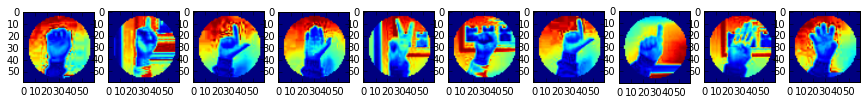

In [9]:
# Check random sample of training images
display_random_imgs(train_images[0], 10)

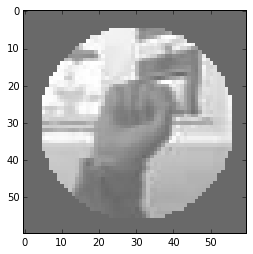

In [10]:
# Images above are shown with color, but are actually in grayscale (as seen below)
show_image(train_images[0][0])

In [11]:
# Save processed training images and signs into a pickle file
training_processed_zipped = {"images": train_images, "signs": train_signs}
pickle_it(training_processed_zipped, "training_processed_zipped.pkl")

In [12]:
# Process test images
raw_test_images_sign_list = load_pickle("test_images.pkl")
test_images, test_signs = process_images(raw_test_images_sign_list)

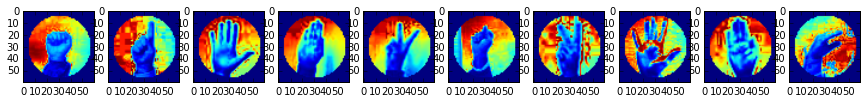

In [13]:
# Check random sample of test images
display_random_imgs(test_images[0], 10)

In [14]:
# Save processed test images and signs into a pickle file
test_processed_zipped = {"images": test_images, "signs": test_signs}
pickle_it(test_processed_zipped, "test_processed_zipped.pkl")